In [1]:
import os
IS_COLAB=False

In [2]:
import tensorflow as tf
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [3]:
# !pip install -q efficientnet
# !pip install tensorflow_addons
import re
import os
import numpy as np
import pandas as pd
import random
import math
import tensorflow as tf
import efficientnet.tfkeras as efn
from sklearn import metrics
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras import backend as K
import tensorflow_addons as tfa
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pickle
import json
import tensorflow_hub as tfhub
from datetime import datetime

## Config

In [4]:
class config:
    
    
    SEED = 42
    FOLD_TO_RUN = 0
    FOLDS = 5
    DEBUG = False
    EVALUATE = True
    RESUME = False
    RESUME_EPOCH = None
    
    
    ### Dataset
    BATCH_SIZE = 128 #32* strategy.num_replicas_in_sync
    IMAGE_SIZE = 128 #512
    N_CLASSES = 11198
    
    ### Model
    model_type = 'effnetv1'  
    EFF_NET = 1
    EFF_NETV2 = 's-21k-ft1k'
    FREEZE_BATCH_NORM = False
    head = 'arcface' 
    EPOCHS = 30
    LR = 0.001
    message='baseline'
    
    ### Augmentations
    CUTOUT = False
    
    ### Save-Directory
    save_dir = '../models/LEGACY_models_arcface/'
    
    ### Inference
    KNN = 50
    
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

# Function to seed everything
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    
def is_interactive():
    return 'runtime'    in get_ipython().config.IPKernelApp.connection_file
IS_INTERACTIVE = is_interactive()
print(IS_INTERACTIVE)

True


## Model

In [5]:
# Arcmarginproduct class keras layer
class ArcMarginProduct(tf.keras.layers.Layer):
    '''
    Implements large margin arc distance.

    Reference:
        https://arxiv.org/pdf/1801.07698.pdf
        https://github.com/lyakaap/Landmark2019-1st-and-3rd-Place-Solution/
            blob/master/src/modeling/metric_learning.py
    '''
    def __init__(self, n_classes, s=30, m=0.50, easy_margin=False,
                 ls_eps=0.0, **kwargs):

        super(ArcMarginProduct, self).__init__(**kwargs)

        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.ls_eps = ls_eps
        self.easy_margin = easy_margin
        self.cos_m = tf.math.cos(m)
        self.sin_m = tf.math.sin(m)
        self.th = tf.math.cos(math.pi - m)
        self.mm = tf.math.sin(math.pi - m) * m

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'n_classes': self.n_classes,
            's': self.s,
            'm': self.m,
            'ls_eps': self.ls_eps,
            'easy_margin': self.easy_margin,
        })
        return config

    def build(self, input_shape):
        super(ArcMarginProduct, self).build(input_shape[0])

        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[0][-1]), self.n_classes),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True,
            regularizer=None)

    def call(self, inputs):
        X, y = inputs
        y = tf.cast(y, dtype=tf.int32)
        cosine = tf.matmul(
            tf.math.l2_normalize(X, axis=1),
            tf.math.l2_normalize(self.W, axis=0)
        )
        sine = tf.math.sqrt(1.0 - tf.math.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = tf.where(cosine > 0, phi, cosine)
        else:
            phi = tf.where(cosine > self.th, phi, cosine - self.mm)
        one_hot = tf.cast(
            tf.one_hot(y, depth=self.n_classes),
            dtype=cosine.dtype
        )
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.n_classes

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output

In [6]:
EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
        efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6, efn.EfficientNetB7]

def freeze_BN(model):
    # Unfreeze layers while leaving BatchNorm layers frozen
    for layer in model.layers:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = False

# Function to create our EfficientNetB3 model
def get_model():

    if config.head=='arcface':
        head = ArcMarginProduct
    else:
        assert 1==2, "INVALID HEAD"
    
    with strategy.scope():
        
        margin = head(
            n_classes = config.N_CLASSES, 
            s = 30, 
            m = 0.3, 
            name=f'head/{config.head}', 
            dtype='float32'
            )

        inp = tf.keras.layers.Input(shape = [config.IMAGE_SIZE, config.IMAGE_SIZE, 3], name = 'inp1')
        label = tf.keras.layers.Input(shape = (), name = 'inp2')
        
        if config.model_type == 'effnetv1':
            x = EFNS[config.EFF_NET](weights = 'imagenet', include_top = False)(inp)
            embed = tf.keras.layers.GlobalAveragePooling2D()(x)
        elif config.model_type == 'effnetv2':
            FEATURE_VECTOR = f'{EFFNETV2_ROOT}/tfhub_models/efficientnetv2-{config.EFF_NETV2}/feature_vector'
            embed = tfhub.KerasLayer(FEATURE_VECTOR, trainable=True)(inp)
            
        embed = tf.keras.layers.Dropout(0.2)(embed)
        embed = tf.keras.layers.Dense(512)(embed)
        x = margin([embed, label])
        
        output = tf.keras.layers.Softmax(dtype='float32')(x)
        
        model = tf.keras.models.Model(inputs = [inp, label], outputs = [output])
        embed_model = tf.keras.models.Model(inputs = inp, outputs = embed)  
        
        opt = tf.keras.optimizers.Adam(learning_rate = config.LR)
        if config.FREEZE_BATCH_NORM:
            freeze_BN(model)

        model.compile(
            optimizer = opt,
            loss = [tf.keras.losses.SparseCategoricalCrossentropy()],
            metrics = [tf.keras.metrics.SparseCategoricalAccuracy(),tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)]
            ) 
        
        return model,embed_model

In [7]:

K.clear_session()
model,embed_model = get_model()
model.summary()

model.load_weights("../models/LEGACY_models_arcface/effnetv1_b1_new_loss.h5")

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp1 (InputLayer)               [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
efficientnet-b1 (Functional)    (None, None, None, 1 6575232     inp1[0][0]                       
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 1280)         0           efficientnet-b1[0][0]            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 1280)         0           global_average_pooling2d[0][0]   
______________________________________________________________________________________________

## Model agnostic test

In [13]:
import os 
import sys

import numpy as np

from glob import glob
from PIL import Image
partial_path = os.getcwd().rsplit("/", 1)[0]
sys.path.insert(0, f"{partial_path}/src/")
import config as cf

import os, json, random, cv2
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf, re, math
from tqdm import tqdm
from glob import glob 
from os.path import join as j
from numpy import random

## Test df

In [15]:
test_path = j('../data/test_BDEO_remapped/')
print(len(os.listdir(test_path)))
all_files = sorted(glob(os.path.join(test_path, '*')), key= lambda x: int(os.path.basename(x).split('_')[0]))

385


In [16]:
query=[]
gallery=[]
for path in all_files:
    pic_id=int(os.path.basename(path).split('_')[1].split('.')[0])
    if pic_id==0:
        query.append(path)
    else:
        gallery.append(path)



In [17]:
len(query)

132

In [18]:
len(gallery)

253

In [19]:
final_dataset_test=[]
dataset_name='test'
query=sorted(query, key= lambda x: int(os.path.basename(x).split('_')[0]))
dataset_df=pd.DataFrame(zip(query, [dataset_name+'_'+(os.path.basename(i).split('_')[0]) for i in query]), columns=['image','damage_id'])
dataset_df['individual_id']=dataset_df['damage_id'].apply(lambda x:int(x.split('_')[-1]))
dataset_df['fold']='test_query'

if len(final_dataset_test)<1:
    final_dataset_test=dataset_df
    
gallery=sorted(gallery, key= lambda x: int(os.path.basename(x).split('_')[0]))
dataset_df=pd.DataFrame(zip(gallery, [dataset_name+'_'+(os.path.basename(i).split('_')[0]) for i in gallery]), columns=['image','damage_id'])
dataset_df['individual_id']=dataset_df['damage_id'].apply(lambda x:int(x.split('_')[-1]))
dataset_df['fold']='test_gallery'

final_dataset_test=pd.concat([final_dataset_test, dataset_df]).reset_index(drop=True)



In [20]:
test_df=final_dataset_test

In [22]:
test_df.to_pickle('../models/LEGACY_models_arcface/test_df.pkl')

In [23]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_example(image,image_name,target):
    feature = {
        'image': _bytes_feature(image),
        'image_name': _bytes_feature(image_name),
        'target': _int64_feature(target)
      }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

In [28]:
def create_test_tf_records(fold  = 0):
    df = test_df[test_df.fold==fold]
    tfr_filename = f'../data/tfrecord_BDEO_-test-{fold}-{df.shape[0]}.tfrec'
    with tf.io.TFRecordWriter(tfr_filename) as writer:
        for i,row in df.iterrows():
            image_id = row.image
            target = row.individual_id
            image_path = image_id
            image_encoded = tf.io.read_file(image_path)
            image_name = str.encode(image_id)
            example = serialize_example(image_encoded,image_name,target)
            writer.write(example)

In [29]:
import joblib
_ = joblib.Parallel(n_jobs=8)(
        joblib.delayed(create_test_tf_records)(fold) for fold in tqdm(test_df['fold'].unique())
    )

100%|██████████| 2/2 [00:00<00:00, 1169.31it/s]


## Evaluation

In [8]:
from glob import glob


In [40]:
def arcface_format(posting_id, image, label_group, matches):
    return posting_id, {'inp1': image, 'inp2': label_group}, label_group, matches

def arcface_inference_format(posting_id, image, label_group, matches):
    return image,posting_id

def arcface_eval_format(posting_id, image, label_group, matches):
    return image,label_group

# Data augmentation function
def data_augment(posting_id, image, label_group, matches):

    ### CUTOUT
    if tf.random.uniform([])>0.5 and config.CUTOUT:
      N_CUTOUT = 6
      for cutouts in range(N_CUTOUT):
        if tf.random.uniform([])>0.5:
           DIM = config.IMAGE_SIZE
           CUTOUT_LENGTH = DIM//8
           x1 = tf.cast( tf.random.uniform([],0,DIM-CUTOUT_LENGTH),tf.int32)
           x2 = tf.cast( tf.random.uniform([],0,DIM-CUTOUT_LENGTH),tf.int32)
           filter_ = tf.concat([tf.zeros((x1,CUTOUT_LENGTH)),tf.ones((CUTOUT_LENGTH,CUTOUT_LENGTH)),tf.zeros((DIM-x1-CUTOUT_LENGTH,CUTOUT_LENGTH))],axis=0)
           filter_ = tf.concat([tf.zeros((DIM,x2)),filter_,tf.zeros((DIM,DIM-x2-CUTOUT_LENGTH))],axis=1)
           cutout = tf.reshape(1-filter_,(DIM,DIM,1))
           image = cutout*image

    image = tf.image.random_flip_left_right(image)
    # image = tf.image.random_flip_up_down(image)
    image = tf.image.random_hue(image, 0.01)
    image = tf.image.random_saturation(image, 0.70, 1.30)
    image = tf.image.random_contrast(image, 0.80, 1.20)
    image = tf.image.random_brightness(image, 0.10)
    return posting_id, image, label_group, matches


# Function to decode our images
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels = 3)
    image = tf.image.resize(image, [config.IMAGE_SIZE,config.IMAGE_SIZE])
    image = tf.cast(image, tf.float32) / 255.0
    return image

# This function parse our images and also get the target variable
def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64),
#         "matches": tf.io.FixedLenFeature([], tf.string)
    }

    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    posting_id = example['image_name']
    image = decode_image(example['image'])
#     label_group = tf.one_hot(tf.cast(example['label_group'], tf.int32), depth = N_CLASSES)
    label_group = tf.cast(example['target'], tf.int32)
#     matches = example['matches']
    matches = 1
    return posting_id, image, label_group, matches


def load_dataset(filenames, ordered = False):
    
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False 
        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO)
#     dataset = dataset.cache()
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls = AUTO) 
    return dataset

def get_test_dataset(filenames, get_names = True):
    dataset = load_dataset(filenames, ordered = True)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_inference_format, num_parallel_calls = AUTO)
    if not get_names:
        dataset = dataset.map(lambda image, posting_id: image)
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

# This function is to get our training tensors
def get_eval_dataset(filenames, get_targets = True):
    dataset = load_dataset(filenames, ordered = True)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_eval_format, num_parallel_calls = AUTO)
    if not get_targets:
        dataset = dataset.map(lambda image, target: image)
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_ids(filename):
    ds = get_test_dataset([filename],get_names=True).map(
        lambda image, image_name: image_name).unbatch()
    NUM_IMAGES = count_data_items([filename])
    ids = next(iter(ds.batch(NUM_IMAGES))).numpy().astype('U')
    return ids

def get_targets(filename):
    ds = get_eval_dataset([filename],get_targets=True).map(lambda image, target: target).unbatch()
    NUM_IMAGES = count_data_items([filename])
    ids = next(iter(ds.batch(NUM_IMAGES))).numpy()
    return ids

def get_embeddings(filename):
    ds = get_test_dataset([filename],get_names=False)
    embeddings = embed_model.predict(ds,verbose=0)
    return embeddings



In [49]:
q_filename=glob(f'../data/tfrecord_BDEO_-test-test_query-*.tfrec')[0]
query_feat = get_embeddings(q_filename)
query = get_ids(q_filename)
query_idx= get_targets(q_filename)

In [50]:
g_filename=glob(f'../data/tfrecord_BDEO_-test-test_gallery-*.tfrec')[0]
gallery_feat = get_embeddings(g_filename)
gallery = get_ids(g_filename)
gallery_idx= get_targets(g_filename)

### GET RESULTS 

In [51]:
from test_utils import test_agnostic_get_metrics, test_agnostic_show_pics

In [45]:
# test_agnostic_show_pics(query,query_idx,  query_feat,
#                gallery,gallery_idx,  gallery_feat)

  0%|          | 0/132 [00:00<?, ?it/s]

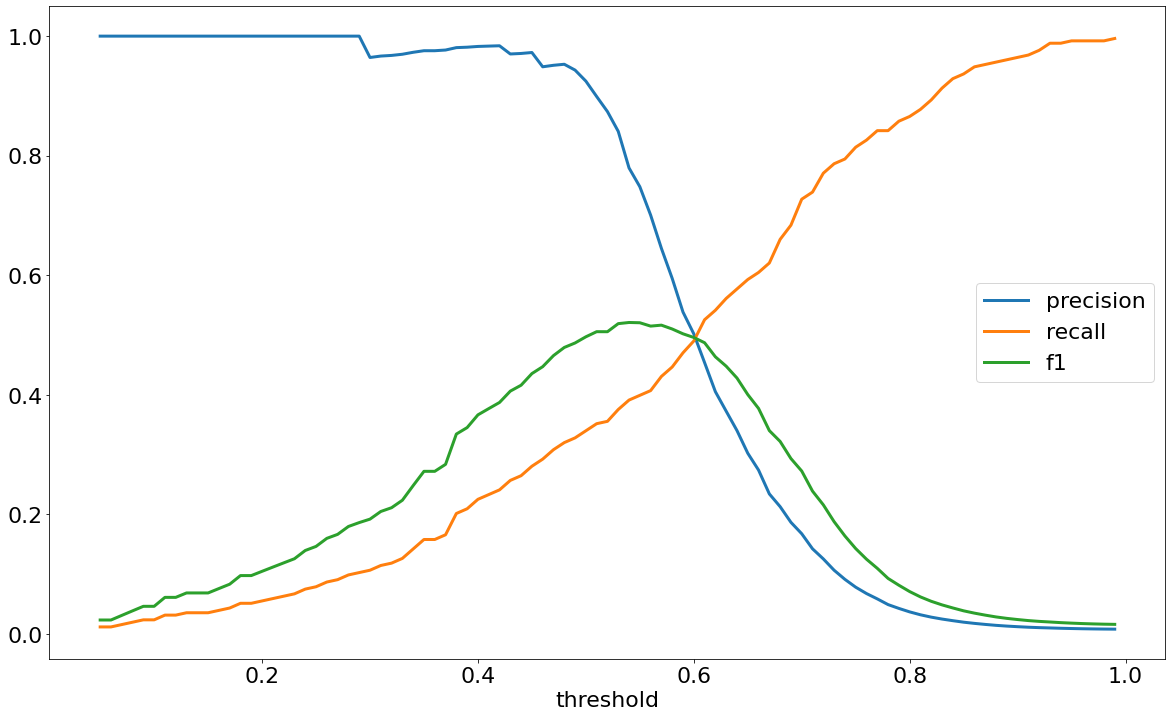

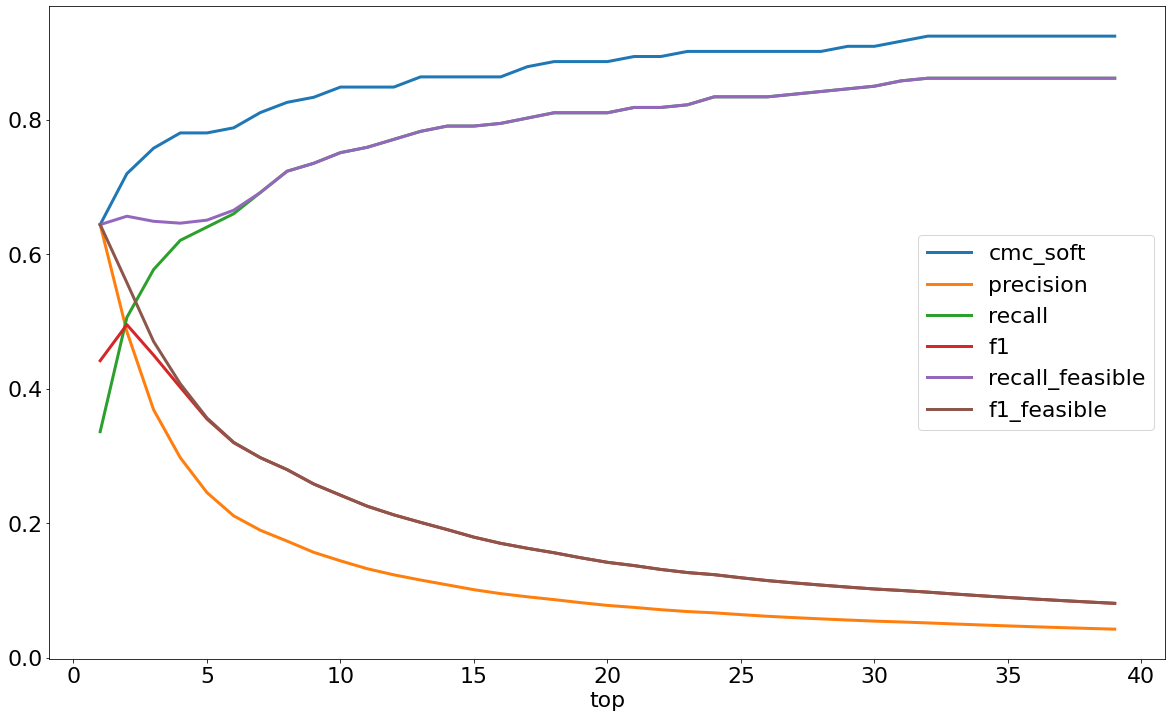

In [52]:
out=test_agnostic_get_metrics(query,query_idx,  query_feat,
               gallery,gallery_idx,  gallery_feat, 
               thresholds=np.arange(0.05,1,0.01), top=list(reversed(range(40)))[0:-1])

In [57]:
out=test_agnostic_get_metrics(query,query_idx,  query_feat,
               gallery,gallery_idx,  gallery_feat, 
               thresholds=np.arange(0.44,0.68,0.02), top=(10, 5, 3, 1),
               display_metrics=True, plot_curves=False)

  0%|          | 0/132 [00:00<?, ?it/s]

,top,precision,recall,recall_feasible,f1,f1_feasible,cmc_soft
top_10,10,0.143939,0.750988,0.750988,0.241577,0.241577,0.848485
top_5,5,0.245455,0.640316,0.650602,0.354874,0.356436,0.780303
top_3,3,0.368687,0.577075,0.648889,0.449923,0.470209,0.757576
top_1,1,0.643939,0.335968,0.643939,0.441558,0.643939,0.643939


,threshold,precision,recall,f1
trash_0.44,0.44,0.971014,0.264822,0.416149
trash_0.46,0.46,0.948718,0.292490,0.447130
trash_0.48,0.48,0.952941,0.320158,0.479290
trash_0.5,0.50,0.924731,0.339921,0.497110
trash_0.52,0.52,0.873786,0.355731,0.505618
trash_0.54,0.54,0.779528,0.391304,0.521053
trash_0.56,0.56,0.700680,0.407115,0.515000
trash_0.58,0.58,0.594737,0.446640,0.510158
trash_0.6,0.60,0.502024,0.490119,0.496000
trash_0.62,0.62,0.405325,0.541502,0.463621


In [58]:
out=test_agnostic_get_metrics(query,query_idx,  query_feat,
               gallery,gallery_idx,  gallery_feat, 
               thresholds=np.arange(0.48,1,0.005), top=list(reversed(range(40)))[0:-1], 
               get_summary_metrics=True, plot_curves=False)

  0%|          | 0/132 [00:00<?, ?it/s]

mean average precision (mAP) is: 0.644
top-1 soft-positive Cumulative Matching Characteristics (CMC) is: 0.644
top-5 f1 feasible is : top_5    0.356
Name: f1_feasible, dtype: float64
top-10 f1 feasible is: top_10    0.242
Name: f1_feasible, dtype: float64
recall at 0.95 is:  0.32
recall at 0.9 is:  0.352
recall at 0.5 is:  0.49
